# Imports

In [1]:
!pip install matplotlib basemap
!pip install tables
!pip install torchvision
!pip install torch --upgrade

  Using cached basemap-1.3.7-cp310-cp310-manylinux1_x86_64.whl (860 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)
  Using cached tables-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached numexpr-2.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (381 kB)
  Using cached blosc2-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.9 MB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached torchvision-0.15.2-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached filelock-3.12.2-py3-none-any.whl (10 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl (11.8

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
import os
import fsspec
import gcsfs
import xarray as xr
import torch as th
import torch.nn as nn
from datetime import datetime, timedelta
import sys
import cartopy
import cartopy.crs as ccrs

# Ensure that working directory is forecast_rodeo
if os.path.basename(os.getcwd()) == "experiments":
    # Navigate to forecast_rodeo
    os.chdir(os.path.join("..",".."))
if os.path.basename(os.getcwd()) != "forecast_rodeo_upgrade":
    raise Exception("You must be in the forecast_rodeo_upgrade folder")

# Adds 'experiments' folder to path to load experiments_util
sys.path.insert(0, 'src/experiments')
    
from Visualization_functions import *

mask = th.load('results/matrix/mask_tensor_permuted.tensor')

gt_id = "contest_precip" #"contest_tmp2m" or ""contest_precip"
target_horizon = "56w" #"56w" or "34w"

In [2]:
#load the data
skills_tmp2m_56_initial = th.load('results/tmp2m_56w_results/skills_temp_56_ground.tensor')
skills_tmp2m_56_CASM = th.load('results/tmp2m_56w_results/skills_temp_56_CASM.tensor')
skills_tmp2m_56_GPP = th.load('results/tmp2m_56w_results/skills_temp_56_GPP.tensor')
skills_tmp2m_56_RECO = th.load('results/tmp2m_56w_results/skills_temp_56_RECO.tensor')
skills_tmp2m_56_elevation = th.load('results/tmp2m_56w_results/skills_temp_56_elevation.tensor')
skills_tmp2m_56_elnino = th.load('results/tmp2m_56w_results/skills_temp_56_elnino.tensor')
skills_tmp2m_56_CASM_GPP_RECO = th.load('results/tmp2m_56w_results/skills_temp_56_CASM_GPP_RECO.tensor')

skills_tmp2m_34_initial = th.load('results/tmp2m_34w_results/skills_temp_34_ground.tensor')
skills_tmp2m_34_CASM = th.load('results/tmp2m_34w_results/skills_temp_34_CASM.tensor')
skills_tmp2m_34_GPP = th.load('results/tmp2m_34w_results/skills_temp_34_GPP.tensor')
skills_tmp2m_34_RECO = th.load('results/tmp2m_34w_results/skills_temp_34_RECO.tensor')
skills_tmp2m_34_elevation = th.load('results/tmp2m_34w_results/skills_temp_34_elevation.tensor')
skills_tmp2m_34_elnino = th.load('results/tmp2m_34w_results/skills_temp_34_elnino.tensor')

skills_precip_56_initial = th.load('results/precip_56w_results/skills_precip_56_ground.tensor')
skills_precip_56_CASM = th.load('results/precip_56w_results/skills_precip_56_CASM.tensor')
skills_precip_56_GPP = th.load('results/precip_56w_results/skills_precip_56_GPP.tensor')
skills_precip_56_RECO = th.load('results/precip_56w_results/skills_precip_56_RECO.tensor')
skills_precip_56_elevation = th.load('results/precip_56w_results/skills_precip_56_elevation.tensor')
skills_precip_56_CASM_GPP_RECO = th.load('results/precip_56w_results/skills_precip_56_CASM_GPP_RECO.tensor')

skills_precip_34_initial = th.load('results/precip_34w_results/skills_precip_34_ground.tensor')
skills_precip_34_CASM = th.load('results/precip_34w_results/skills_precip_34_CASM.tensor')
skills_precip_34_GPP = th.load('results/precip_34w_results/skills_precip_34_GPP.tensor')
skills_precip_34_RECO = th.load('results/precip_34w_results/skills_precip_34_RECO.tensor')
skills_precip_34_elevation = th.load('results/precip_34w_results/skills_precip_34_elevation.tensor')
skills_precip_34_elnino = th.load('results/precip_34w_results/skills_precip_34_elnino.tensor')

SHAP_precip_56w_all_2012 = th.load('results/precip_56w_results/SHAP_precip_56_all_2012.tensor')
SHAP_tmp2m_56w_all_2016 = th.load('results/tmp2m_56w_results/SHAP_temp_56_all_2016.tensor')

In [3]:
### Parameters
year = 2016
tensor_basis = skills_precip_56_initial
tensor_basis_and_feature = skills_precip_56_RECO
feature = "RECO"

if gt_id == "contest_tmp2m":
    if target_horizon == "56w":
        indexes = ['lat', 'lon', 'start_date', 'rhum_shift44', 'pres_shift44',
           'GPP_shift44', 'RECO_shift44', 'CASM_soil_moisture_shift44',
           'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa', 'tmp2m_clim', 'tmp2m_anom',
           'tmp2m_shift43', 'tmp2m_shift43_anom', 'tmp2m_shift86',
           'tmp2m_shift86_anom', 'mei_shift59', 'phase_shift31',
           'sst_2010_1_shift44', 'sst_2010_2_shift44', 'sst_2010_3_shift44',
           'icec_2010_1_shift44', 'icec_2010_2_shift44', 'icec_2010_3_shift44',
           'wind_hgt_10_2010_1_shift44', 'wind_hgt_10_2010_2_shift44', 'CASM', 'GPP', 'RECO', 'elevation', 'ElNino1', 'ElNino34', 'ElNino4'] #####ADD tmp2m forgotten
    if target_horizon == "34w":
        indexes = ['lat','lon','start_date','rhum_shift30','pres_shift30',
               'GPP_shift30','RECO_shift30','CASM_soil_moisture_shift29',
               'nmme_wo_ccsm3_nasa','nmme0_wo_ccsm3_nasa','tmp2m_clim','tmp2m_anom',
               'tmp2m_shift29','tmp2m_shift29_anom','tmp2m_shift58',
               'tmp2m_shift58_anom', 'mei_shift45','phase_shift17',
               'sst_2010_1_shift30','sst_2010_2_shift30','sst_2010_3_shift30',
               'icec_2010_1_shift30','icec_2010_2_shift30','icec_2010_3_shift30',
               'wind_hgt_10_2010_1_shift30','wind_hgt_10_2010_2_shift30','CASM','GPP', 'RECO', 'elevation', 'ElNino1', 'ElNino34', 'ElNino4']
    index_feature = indexes.index(feature) #change it depending the feature you want to study

if gt_id == "contest_precip":
    if target_horizon == "56w":
        indexes =  ['lat','lon','start_date','rhum_shift44','pres_shift44',
                'GPP_shift44','RECO_shift44','CASM_soil_moisture_shift44','nmme_wo_ccsm3_nasa','nmme0_wo_ccsm3_nasa',
                'precip','precip_clim','precip_anom','precip_shift43','precip_shift43_anom',
                'tmp2m_shift43','tmp2m_shift43_anom','precip_shift86','precip_shift86_anom','tmp2m_shift86',
                'tmp2m_shift86_anom','mei_shift59','phase_shift31','sst_2010_1_shift44','sst_2010_2_shift44',
                'sst_2010_3_shift44','icec_2010_1_shift44','icec_2010_2_shift44','icec_2010_3_shift44','wind_hgt_10_2010_1_shift44',
                'wind_hgt_10_2010_2_shift44','CASM','GPP','RECO','elevation', 'ElNino1', 'ElNino34', 'ElNino4']
    if target_horizon == "34w":
        indexes =  ['lat','lon','start_date','rhum_shift30','pres_shift30',
                'GPP_shift30','RECO_shift30','CASM_soil_moisture_shift29','nmme_wo_ccsm3_nasa','nmme0_wo_ccsm3_nasa',
                'precip','precip_clim','precip_anom','precip_shift29','precip_shift29_anom',
                'tmp2m_shift29','tmp2m_shift29_anom','precip_shift58','precip_shift58_anom','tmp2m_shift58',
                'tmp2m_shift58_anom','mei_shift45','phase_shift17','sst_2010_1_shift30','sst_2010_2_shift30',
                'sst_2010_3_shift30','icec_2010_1_shift30','icec_2010_2_shift30','icec_2010_3_shift30','wind_hgt_10_2010_1_shift30',
                'wind_hgt_10_2010_2_shift30','CASM','GPP','RECO','elevation', 'ElNino1', 'ElNino34', 'ElNino4']
    index_feature = indexes.index(feature) #change it depending the feature you want to study

# SKILLS

## Model's Performances

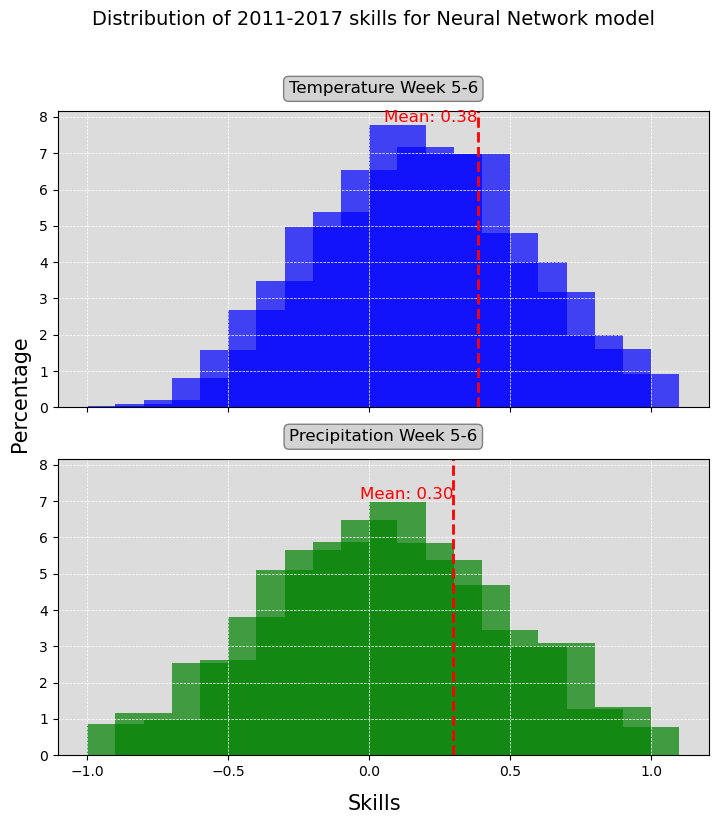

In [5]:
histogram_of_contest_skills(skills_tmp2m_56_initial, skills_precip_56_initial, target_horizon) #Strange results, the mean is much higer than what histograms suggets, probably an error somewhere

## Averaged Year skills compared with RODEO

       methods  mean_skill
0     multillr    0.230014
1      autoknn    0.281000
2     ensemble    0.298800
3  rec_deb_cfs    0.214014
4      ens_cfs    0.322729
5       result    0.216196


/home/jovyan/forecast_rodeo_upgrade/src/experiments/Visualization_functions.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(years, multillr, cmap='Greys', marker='+')
/home/jovyan/forecast_rodeo_upgrade/src/experiments/Visualization_functions.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  plt.plot(years,autoknn,'r-o', label="autoknn", c='0.25')
/home/jovyan/forecast_rodeo_upgrade/src/experiments/Visualization_functions.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(years,ensemble,'b-o', label="ensemble",c='0.45')
/home/jovyan/forecast_rodeo_upgrade/src/experiments/Visualization_functions.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt 

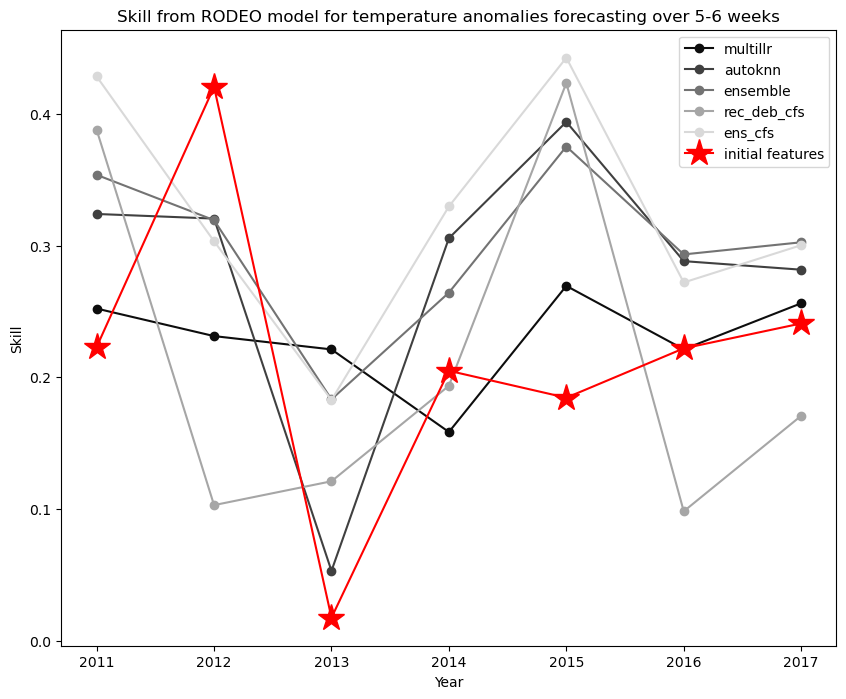

In [5]:
#In ground add the skills vector you want to compare with RODEO
ground = np.array([0.223010872178, 0.42046484884, 0.017528819189, 0.204973527909, 0.184514521519, 0.221982716574, 0.240893769283]) #ex tmp2m56w
#ground = np.array([0.370197091037, 0.372786933082, 0.086824074353, 0.186146836928, 0.204524449127, 0.273203821366, 0.229277659904]) #ex tmp2m34w
#ground =  np.array([0.202278353185,  0.115365052563, -0.050802999766, -0.011977612144, -0.015592060667, -0.001610510414, 0.025886737297]) #ex precip56w
#ground = np.array([0.211572655005, 0.15830281892, -0.071830457873, 0.068592533033, -0.000653787043, -0.021710807469,  0.058167810499]) #ex precip34w

comparison_RODEO(gt_id, target_horizon, ground)

## Geographical comparison of skills with the addition of a new feature

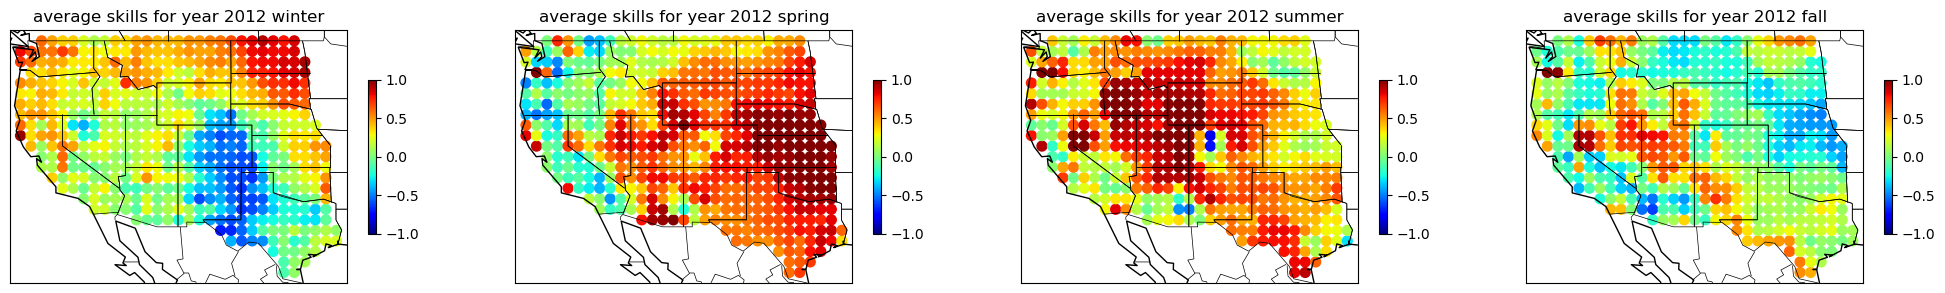

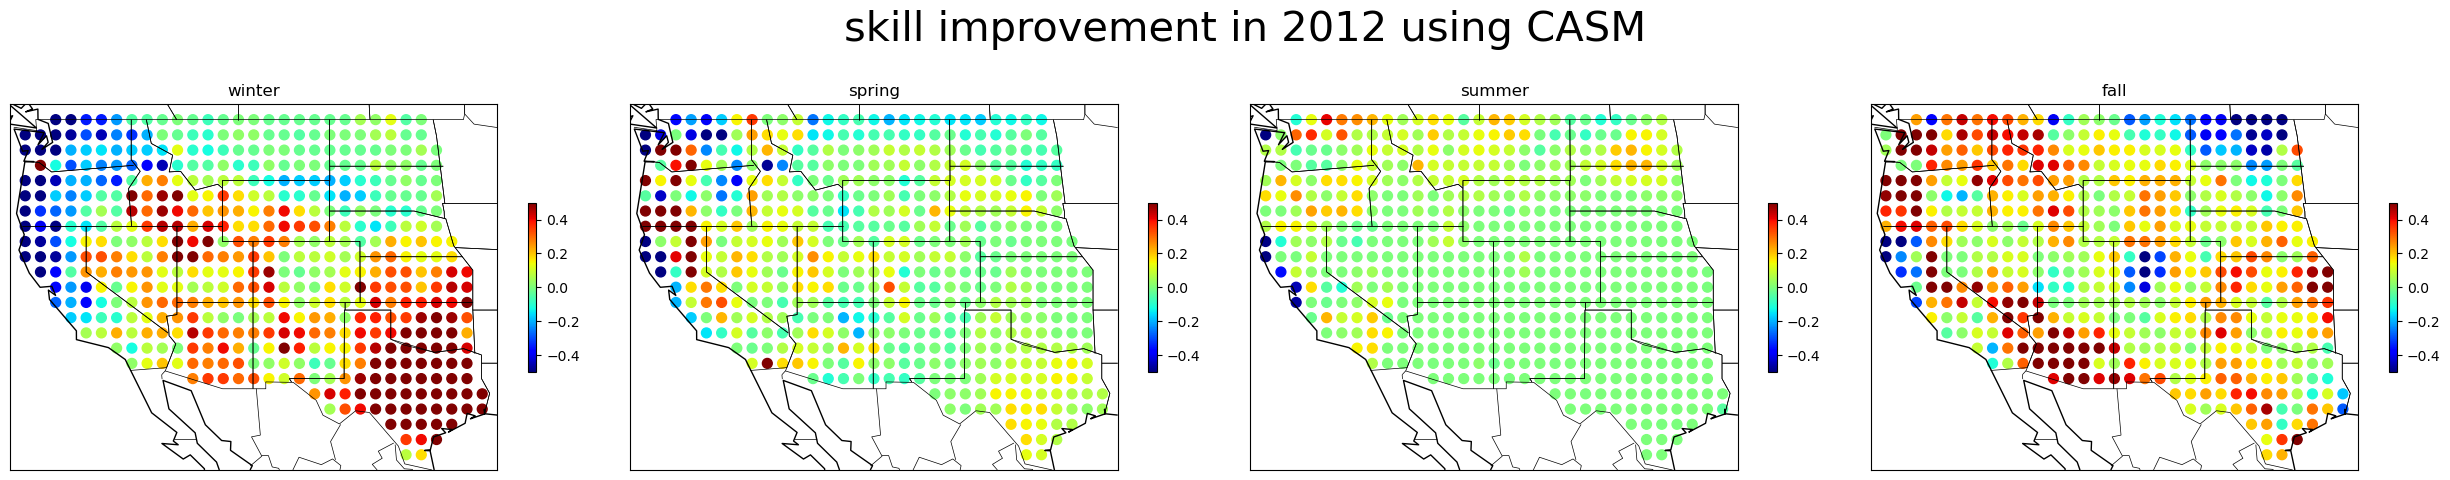

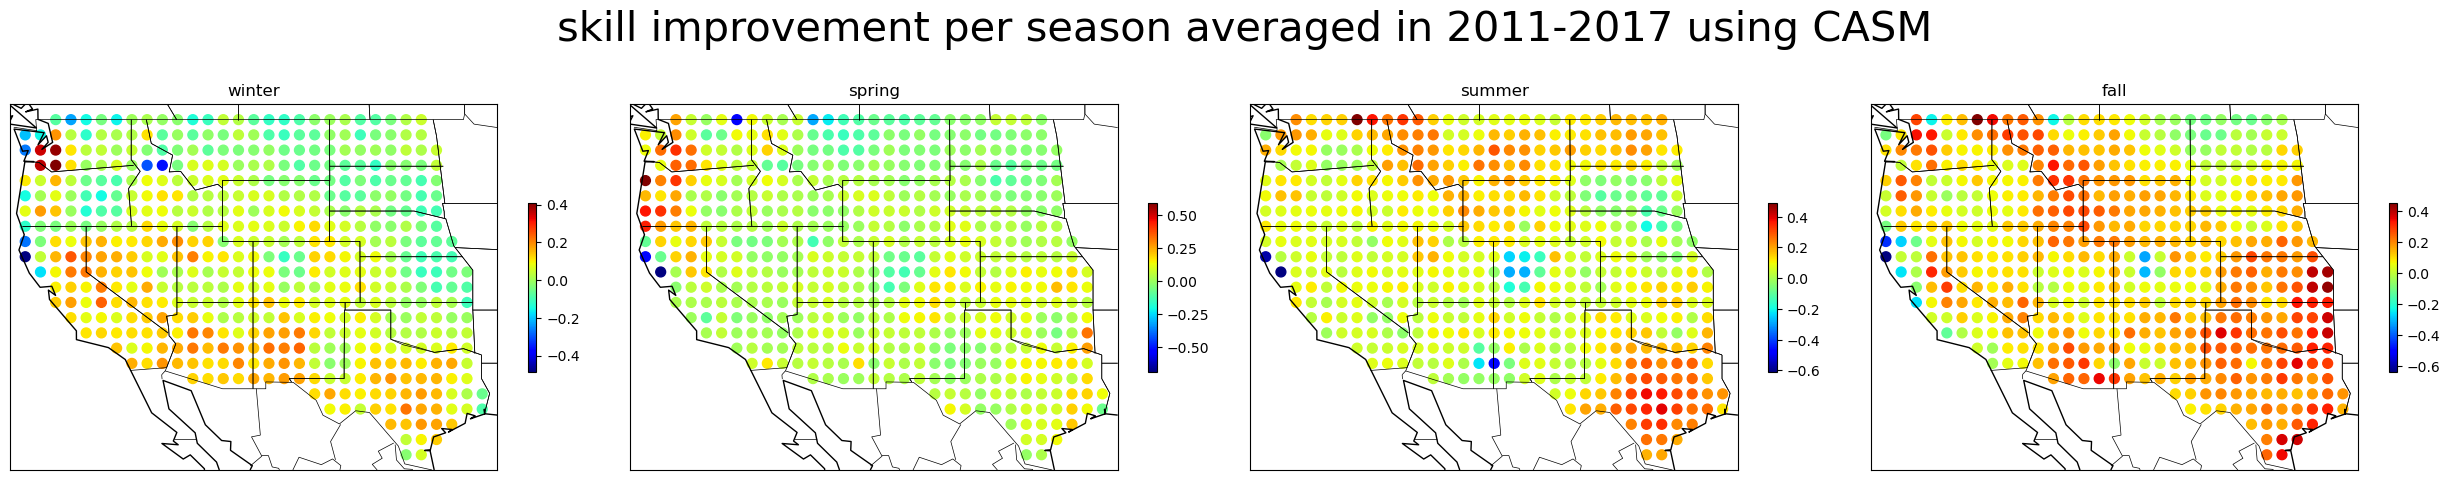

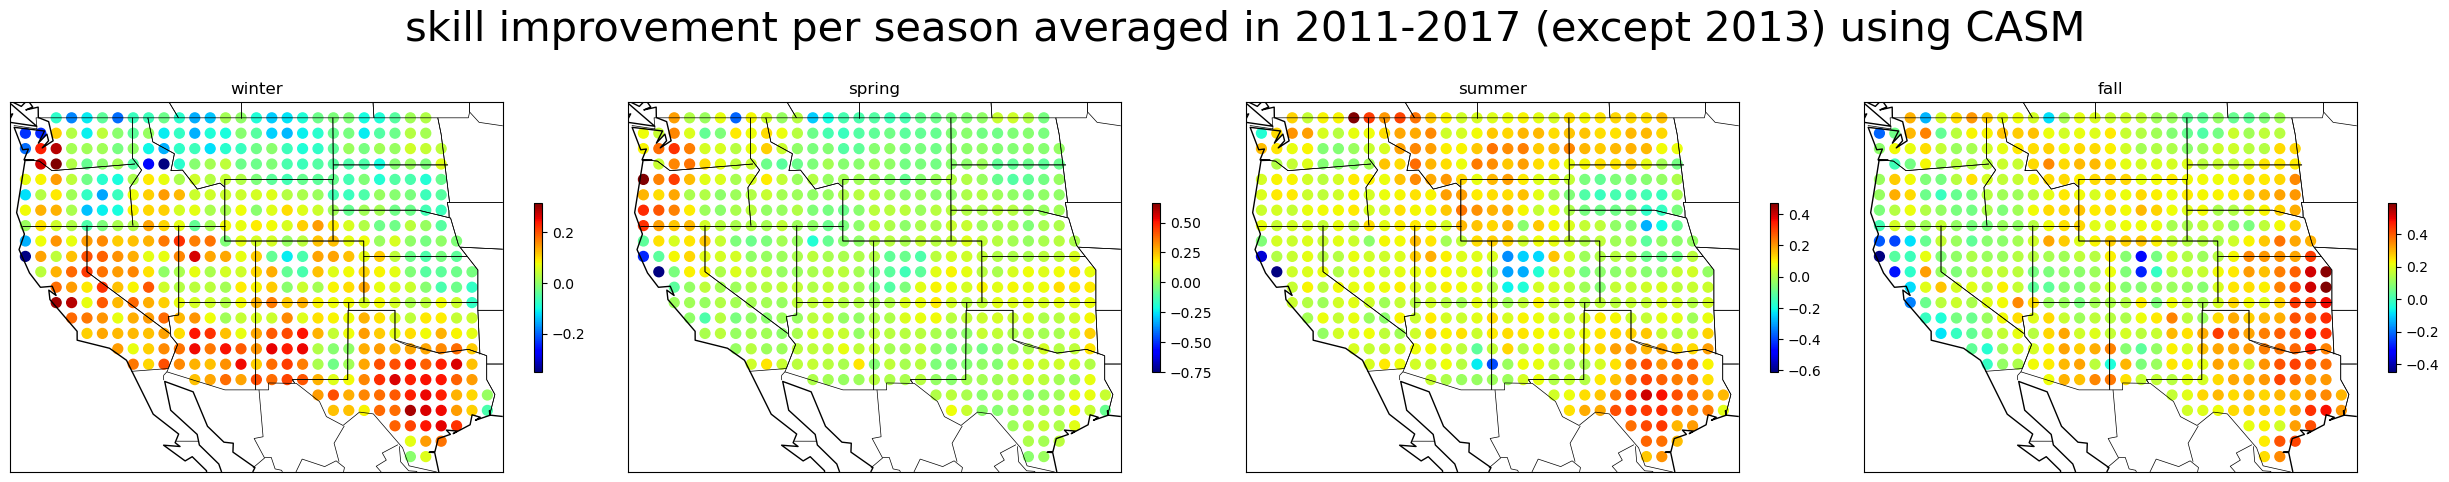

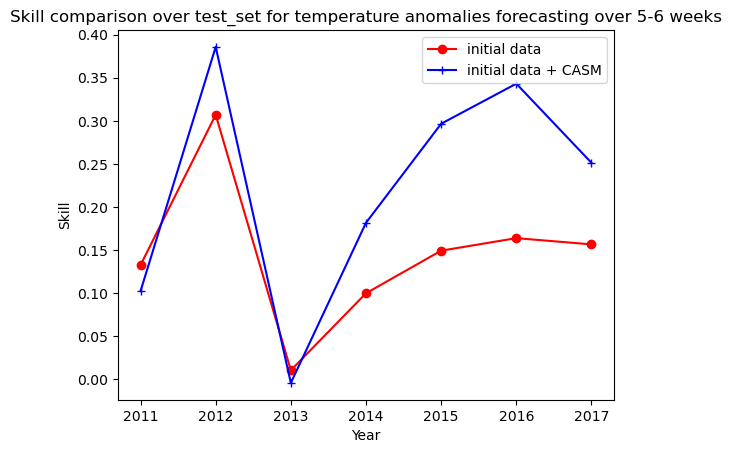

In [6]:
### Interesting plots
plot_skill_simulation(tensor_basis, year, mask) 
differences_skill_simulation(tensor_basis_and_feature, tensor_basis, year, feature, mask)
season_mean(tensor_basis_and_feature, tensor_basis, feature, mask)
season_mean_except_2013(tensor_basis_and_feature, tensor_basis, feature, mask)
subplot_skills(tensor_basis, tensor_basis_and_feature, feature, mask, gt_id, target_horizon)

## Link between skill improvement and features values
Not very useful, difficult to interprete. Code can be modified to change y-axis zone (for example [-100%/+100%], [+10%/+100%] ...

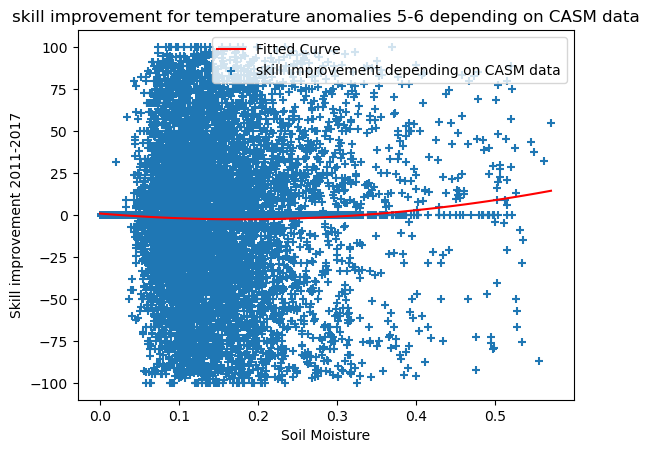

In [7]:
link_improvement_feature(tensor_basis, tensor_basis_and_feature, gt_id, target_horizon, feature, index_feature, mask)

## Climate Zones Analysis

### Define Climate Zones folllowinng Koppen classification

/home/jovyan/forecast_rodeo_upgrade/src/experiments/Visualization_functions.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate_zones['longitude']=df_climate_zones['longitude']+360


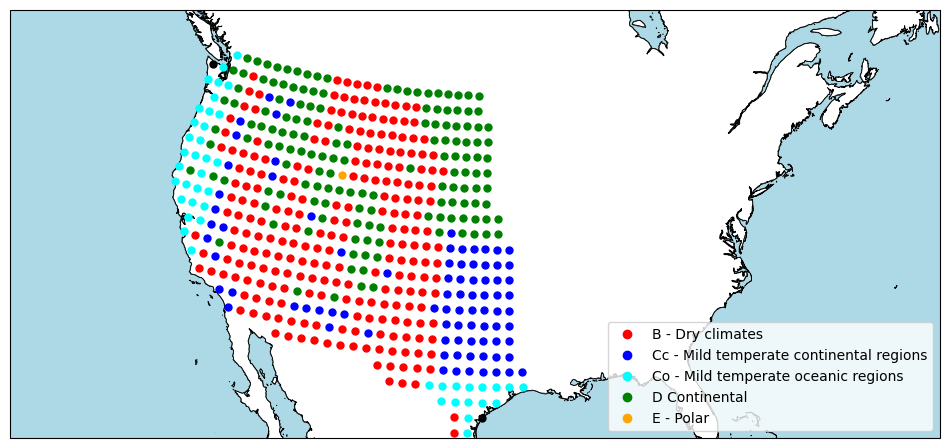

In [4]:
coordinates = climate_zone_preprocess(gt_id, target_horizon)
climate_zone_maps(coordinates)



### Save Koppen Tensor

In [5]:
save_koppen(coordinates)

      lat    lon p1901_2010  Large region
0    27.0  261.0        BSh           1.0
1    27.0  262.0        Cfa           3.0
2    28.0  261.0        BSh           1.0
3    28.0  262.0        Cfa           3.0
4    28.0  263.0        NaN           NaN
..    ...    ...        ...           ...
509  49.0  258.0        Dfb           4.0
510  49.0  259.0        Dfb           4.0
511  49.0  260.0        Dfb           4.0
512  49.0  261.0        Dfb           4.0
513  49.0  262.0        Dfb           4.0

[514 rows x 4 columns]
torch.Size([23, 31])
Saving multiarrays features to results/matrix/Koppen.tensor
Finished generating data matrix.


### Plot Koppen Tensor / Climate Regions

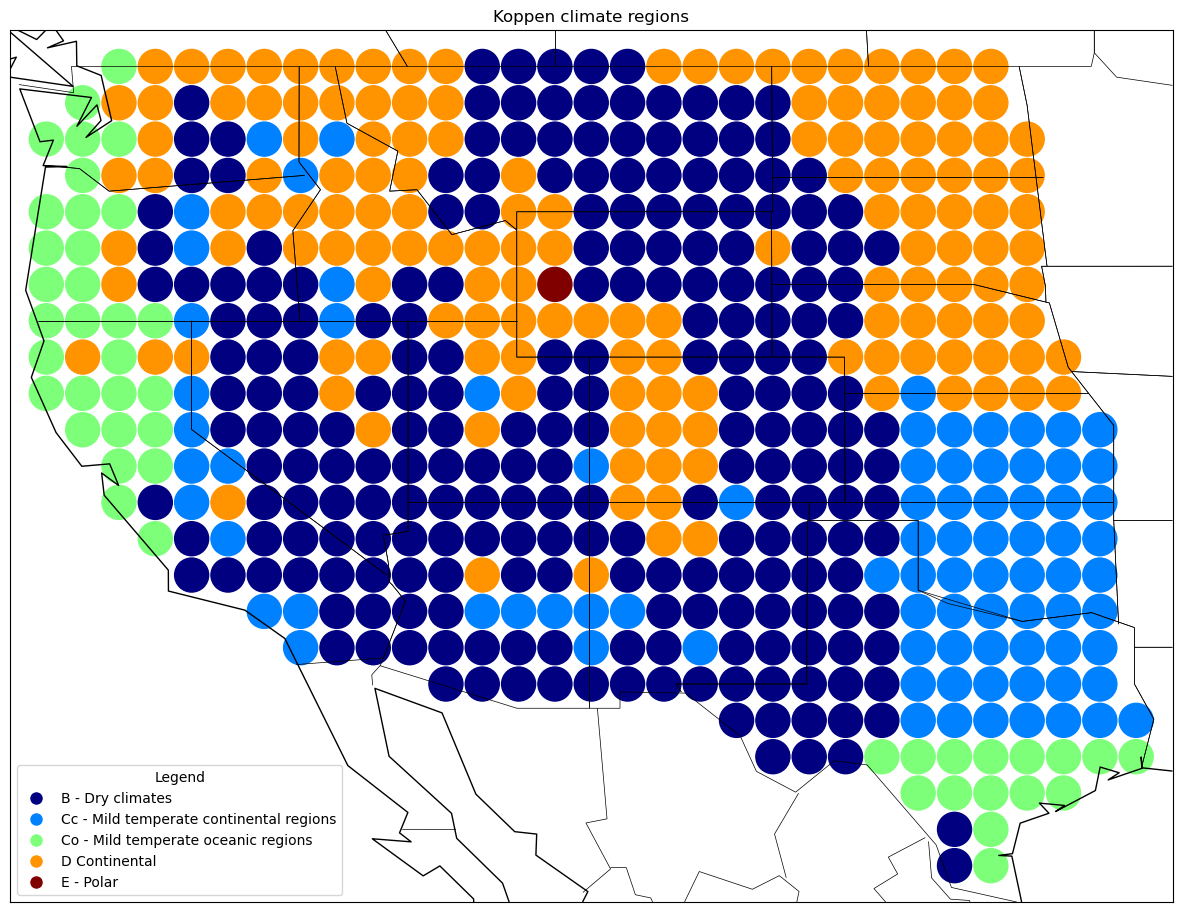

In [4]:
koppen_tensor = th.load('results/matrix/Koppen.tensor') 
plot_koppen(koppen_tensor, mask)

### Quantitative Study

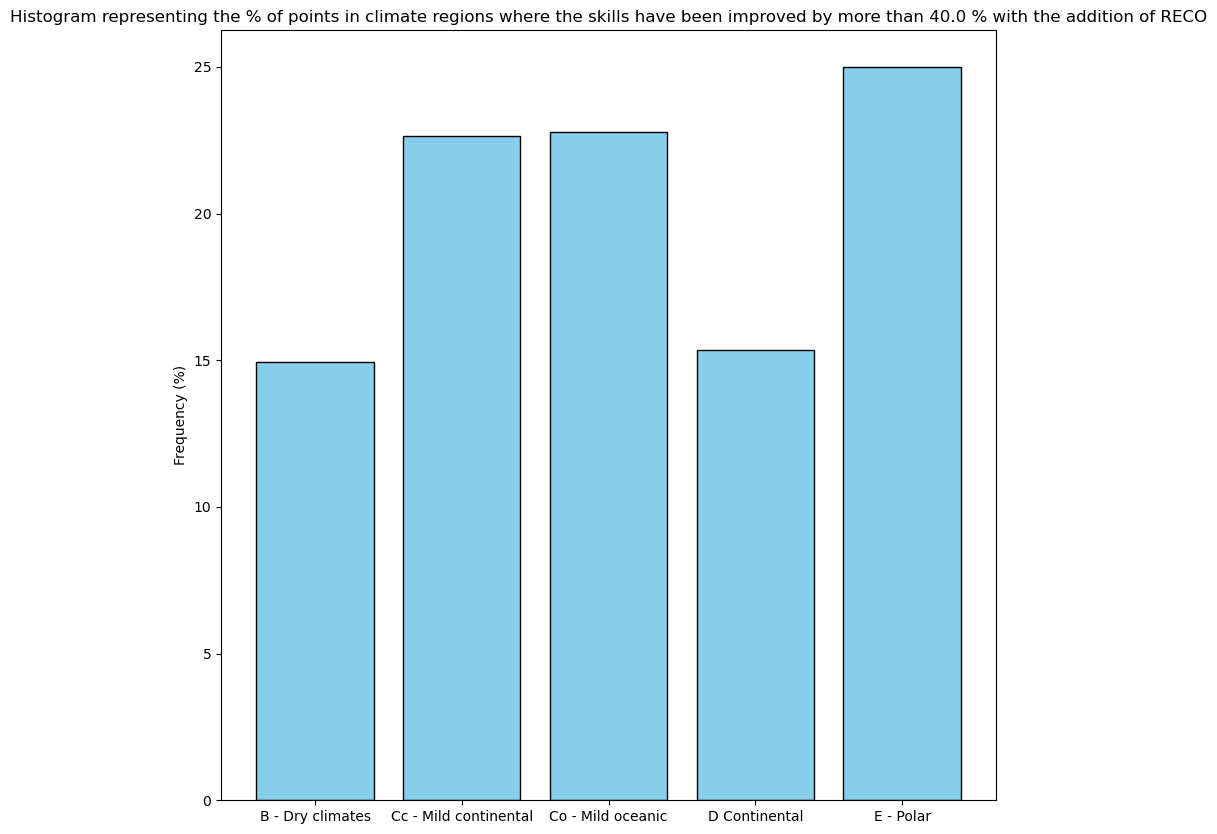

In [4]:
koppen_tensor = th.load('results/matrix/Koppen.tensor') 
climate_histograms_skills(tensor_basis_and_feature, tensor_basis, koppen_tensor, feature , criteria = 0.4)

# SHAP values

### Seasonal SHAP values

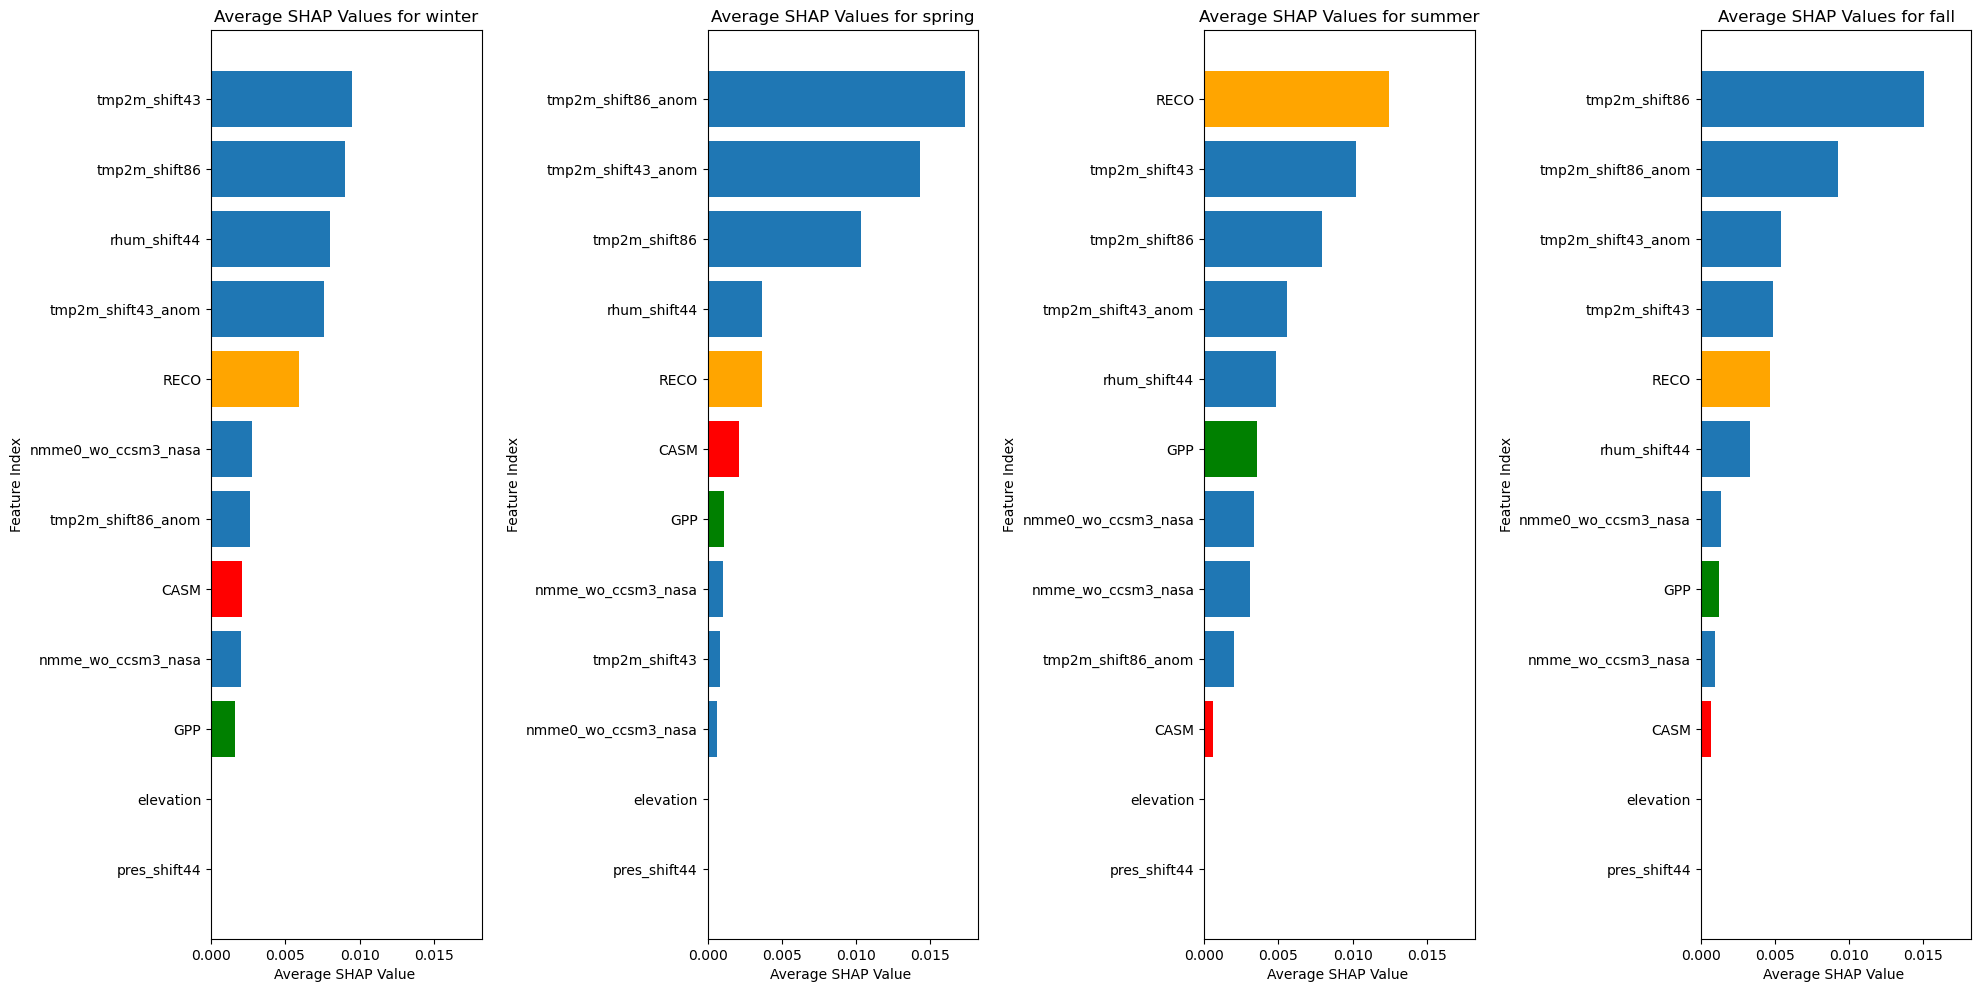

In [4]:
seasonal_SHAP_value(SHAP_tmp2m_56w_all_2016, gt_id)

### Geographical SHAP values

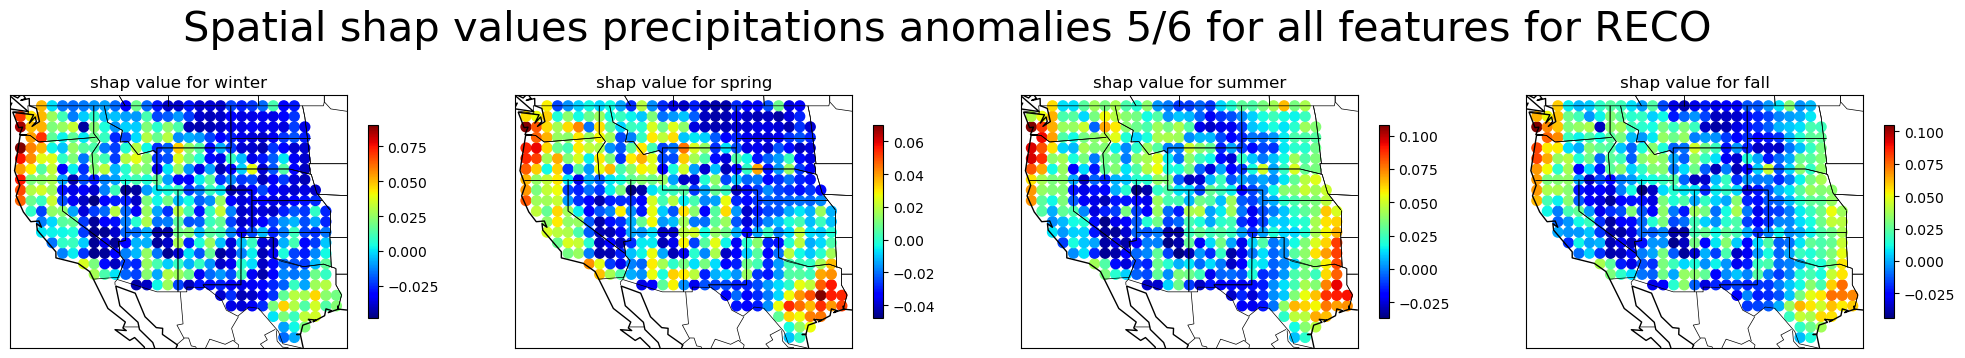

In [4]:
plot_geographical_SHAP(SHAP_tmp2m_56w_all_2016, gt_id, feature, mask)

### Quantitative study

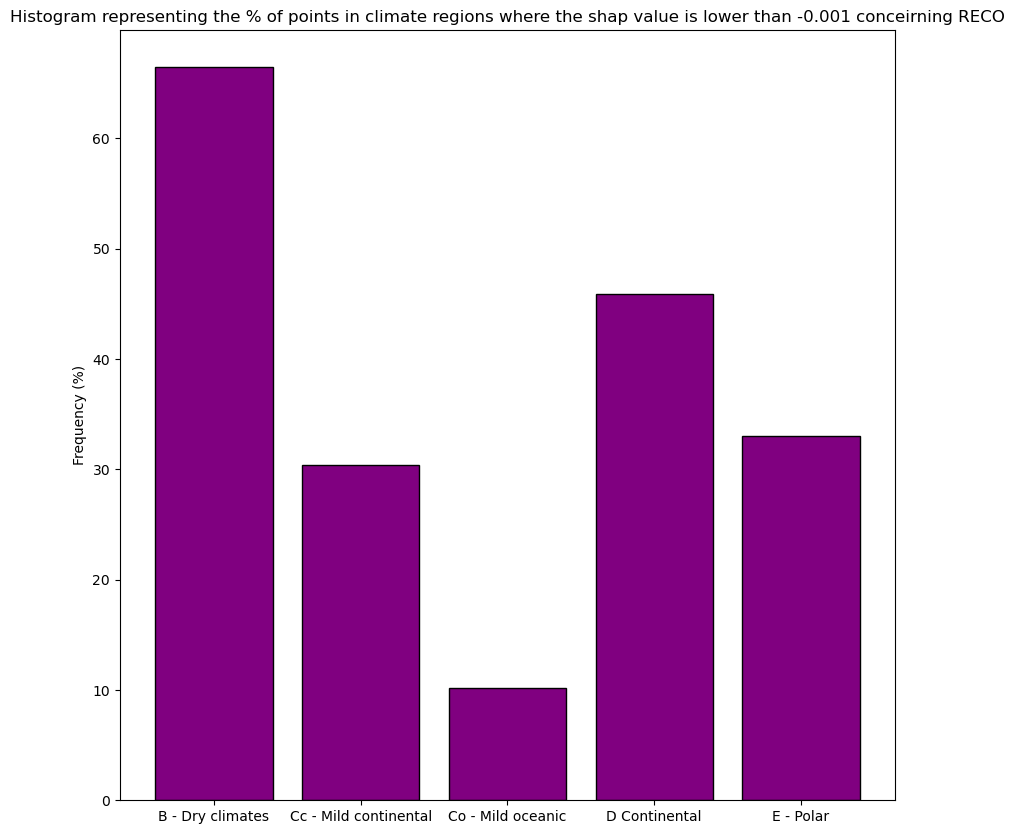

In [5]:
koppen_tensor = th.load('results/matrix/Koppen.tensor') 
climate_histograms_SHAP(SHAP_tmp2m_56w_all_2016, gt_id, feature, koppen_tensor, criteria = -0.001)

# LRP Values

In [5]:
LRP_tmp2m_56_initial = np.array([-0.0158009043, -0.000590487259, 0.000319552152, -0.00030882883, -0.007317348326, 0.064542150683, 0.00929029468, 0.053664105041, -0.000331338904, -0.001802302164,
                       -0.004485292472, -0.033464744954, 0.039027401074, 0.00200192639, -0.013177001337, 0.000819568168, 0.017007595649, -0.03649575868])
LRP_tmp2m_56_CASM = np.array([-2.493143601176e-02, -7.540731317570e-04,  1.568087749908e-06, -6.677498352435e-04, -2.019391377032e-03,  6.153266773150e-02,
  4.713033696325e-03,  5.416275944691e-02, -4.919321330605e-04, -1.705393386490e-03, -5.270159940311e-03, -2.694761112970e-02, 3.489864512640e-02, 3.644353823903e-03, -1.620611235325e-02, 7.085046972282e-03,  7.918876339953e-03, -3.787400805997e-02, 5.530932014554e-02])
LRP_tmp2m_56_GPP= np.array([-0.02771998899, -0.000609355817, -0.00078916421, -0.002005187813, -0.002368877764, 0.057985033414, 0.001238795277, 0.053202446518, 0.002398805854, -0.001415724944, -0.013073402806, -0.021711435578,
  0.028143366209,  0.004643767492, -0.017565526109,  0.004011146985, 0.003706920425, -0.038679379712,  0.068043619])
LRP_tmp2m_56_RECO= np.array([-0.027890751612, -0.001031361503, -0.000745534469, -0.002054829751, -0.002799626817,  0.059530698279,  0.001811835947,  0.054728459013, 0.000167075829, -0.000922084775, -0.01279727587,  -0.021591371692,
  0.027819340702,  0.003677695934, -0.016397983462,  0.004138029225, 0.004544748685, -0.037771571564,  0.068998991376])
LRP_tmp2m_56_elevation = np.array([-0.015273908882, -0.00016227201, 0.000163107525, -0.001475718822, -0.002200038888,  0.062511338705,  0.001633819487,  0.054961973406, -0.000855017532, -0.000147312161, -0.004595657221, -0.032608096052,
  0.038946524297,  0.003828931272, -0.0125227032,    0.001222852925, 0.0195356844,  -0.036043441713, -0.000160594441])
LRP_tmp2m_56_elevation2 = np.array([-1.634601711763e-02, -9.088510893836e-04,  1.600345888026e-03, 4.246117670364e-04, -8.307295811547e-04,  6.261834986943e-02, 3.631608193950e-03,  5.529253547758e-02, -1.170476752873e-03,
 -1.968672720839e-03, -1.670246069765e-03, -3.243334432520e-02, 3.960407049276e-02,  9.786024341787e-04, -1.333646644414e-02, 2.091522462637e-03,  1.814850944489e-02, -3.543072934281e-02, 1.455207974994e-05])
LRP_tmp2m_56_elnino = np.array([-0.015751123614, -0.000364189325, 0.003197347457, 0.001338915196, -0.000525610349,  0.06275808505,   0.003574250459,  0.055069341548, -0.000721310275, -0.001962550106, -0.002585169731, -0.033705343254,
  0.039760808537,  0.002617592686, -0.011702625668,  0.001709858198, 0.018351694025, -0.03515846386,  -0.001115664956, -0.000255982688, -0.000419345605])




LRP_precip_56_CASM = np.array([-2.126626226805e-03,  5.756402757845e-04,  3.697748470631e-03,1.343029760665e-02, -6.686965025353e-04,  2.842613583873e-02,
  8.552937308174e-04,  1.334785626556e-03,  2.731371412945e-03, 1.318755725015e-02,  3.817678773450e-04,  6.652153419613e-03, 3.011236180359e-03,  2.290981906513e-03,  1.297253799346e-03,
 -1.279086918219e-02, -4.742690357253e-02, -8.906749578135e-05, 6.542578652675e-03, -1.001291562611e-02, -4.933809202005e-04, 5.902839773824e-03, -1.222689309473e-02])

['rhum_shift44', 'pres_shift44', 'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa', 'precip_shift43', 'precip_shift43_anom', 'tmp2m_shift43', 'tmp2m_shift43_anom', 'precip_shift86', 'precip_shift86_anom', 'tmp2m_shift86', 'tmp2m_shift86_anom', 'mei_shift59', 'phase_shift31', 'sst_2010_1_shift44', 'sst_2010_2_shift44', 'sst_2010_3_shift44', 'icec_2010_1_shift44', 'icec_2010_2_shift44', 'icec_2010_3_shift44', 'wind_hgt_10_2010_1_shift44', 'wind_hgt_10_2010_2_shift44', 'RECO']
[16 15 22 19  0  4 20 17 10  1  6 14  7 13  8 12  2 21 18 11  9  3  5]


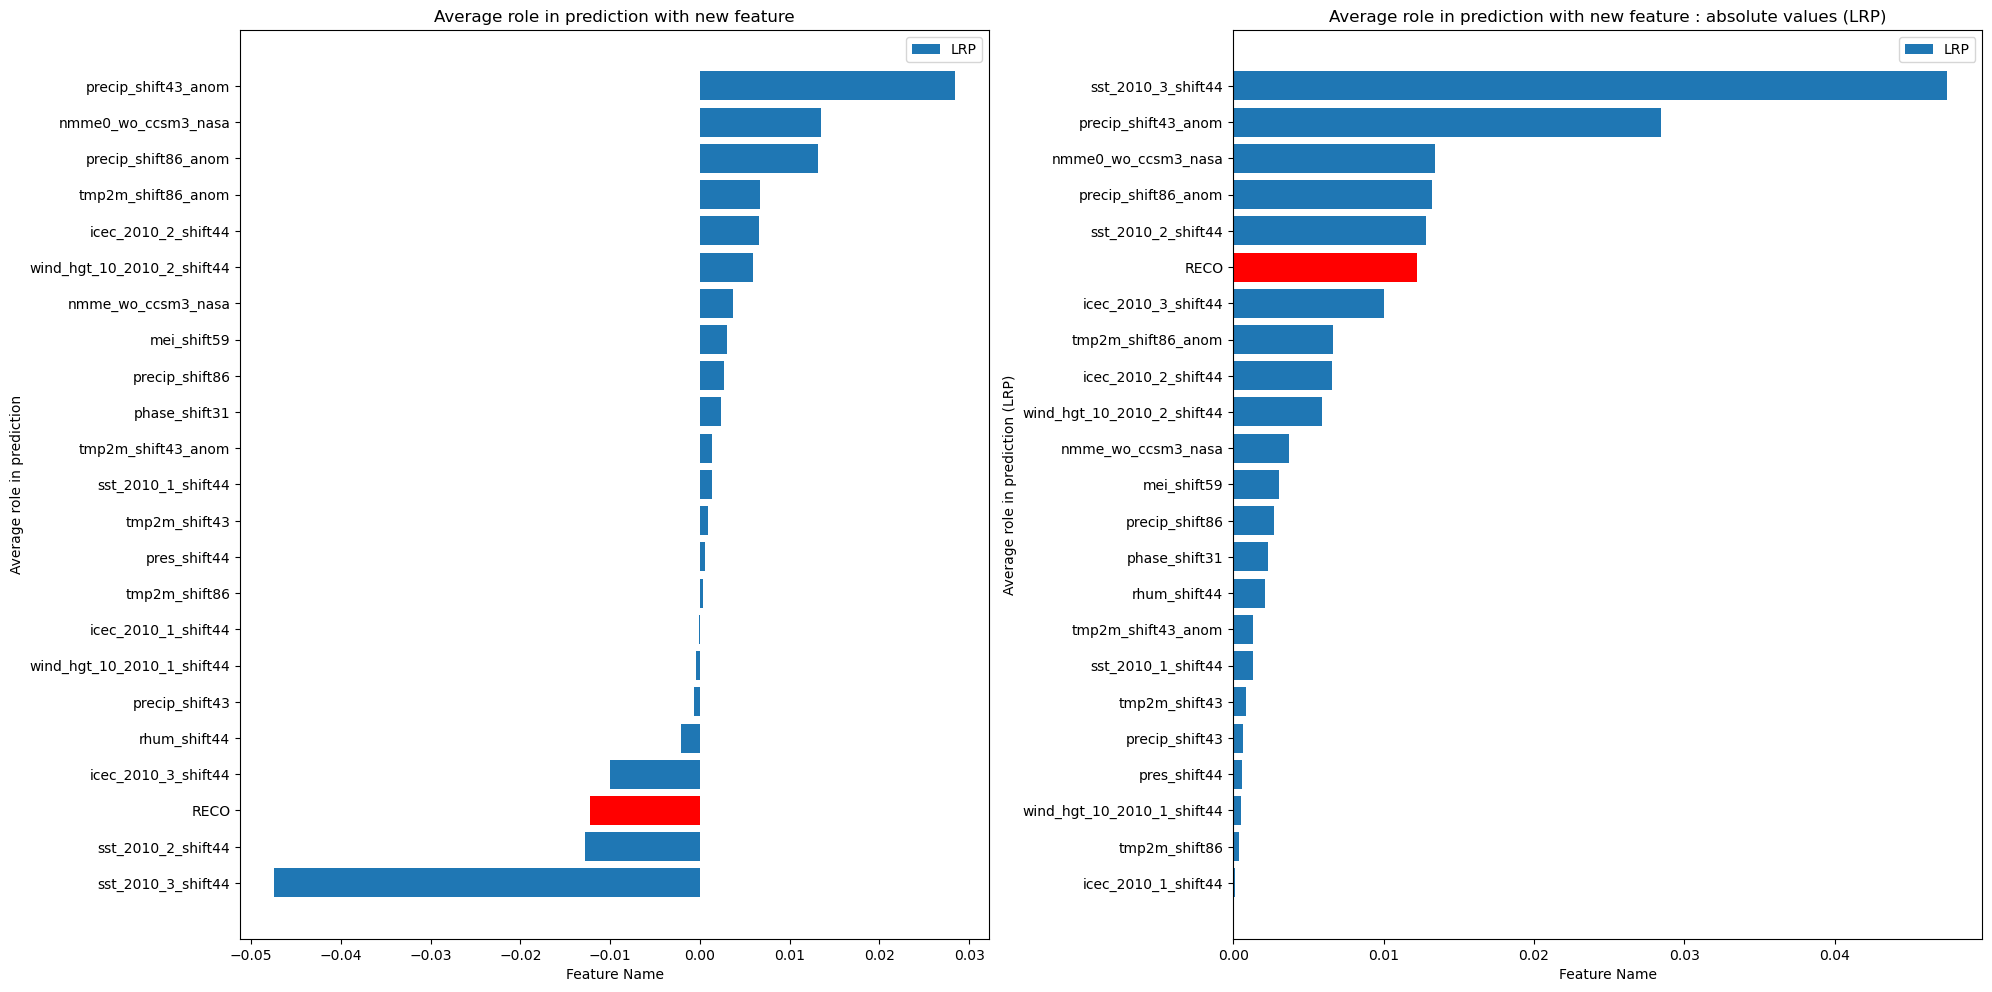

In [6]:
plot_LRP_values(LRP_precip_56_CASM, gt_id, feature)